In [1]:
import numpy as np
import open3d as o3d
import pathlib
import re
from ipywidgets import interact
from lib.datasets.kitti_utils import Calibration
import cv2

%load_ext autoreload
%autoreload 2
from pathlib import Path
from tools.sample_util import SampleDatabase
from tools.dataset_util import Dataset

test_dir = Path("/mnt/e/DataSet/kitti/kitti_inst_database/test")
np.random.seed(0)
import random

random.seed(0)
random_flip = 0.5
database = SampleDatabase("/mnt/e/DataSet/kitti/kitti_inst_database/", random_flip=random_flip)
dataset = Dataset("train", r"/mnt/e/DataSet/kitti")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
from tools.sample_util import to3d
root_dir = Path("/mnt/e/DataSet/kitti/training/image_points")

for idx in range(7481):
    file_name = str(idx).zfill(6) + ".bin" 
    image, depth = dataset.get_image_with_depth(idx, use_penet=False)
    calib = dataset.get_calib(idx)
    h, w = image[:2]
    cord, rgb = to3d(image[200:], depth[200:], calib, bbox2d=[0, 200])
    cord = cord.astype(np.float32)
    cord.tofile(str(root_dir / file_name))
    print(idx)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


KeyboardInterrupt: 

In [ ]:
from tools.sample_util import to3d, to2d
idx = 2
calib = dataset.get_calib(idx)
ground, non_ground = dataset.get_lidar_with_ground(idx, fov=True)
plane = dataset.get_plane(idx)


u = np.arange(0, depth.shape[0])
v = np.arange(0, depth.shape[1])
u, v = np.meshgrid(u, v)
u = u.reshape(-1)
v = v.reshape(-1)

In [23]:

a, b, c, d = plane
P = calib.P2
# Step 1: Convert the point to homogeneous coordinates
uv_homogeneous = np.array([u, v, np.ones_like(u)])

# Step 2: Compute the inverse projection
P2_inv = np.linalg.pinv(P)
ray = np.dot(P2_inv, uv_homogeneous)
uv_homogeneous

array([[   0,    1,    2, ...,  373,  374,  375],
       [   0,    0,    0, ..., 1185, 1185, 1185],
       [   1,    1,    1, ...,    1,    1,    1]])

In [15]:

# Since the ray is lambda * [X, Y, Z, 1]^T, its direction is only the first 3 elements.
direction = ray[:3]

# Step 3: Compute the intersection of the ray with the ground plane
# ax + by + cz + d = 0 => aX + bY + cZ + d = 0 (for homogeneous [X, Y, Z, 1]^T)
# lambda is the scaling factor
lambda_val = -d / (a * direction[0] + b * direction[1] + c * direction[2])

# Step 4: Compute the ground point
ground_point = lambda_val * direction


/tmp/ipykernel_18299/3417347971.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  uv_homogeneous = np.array([u, v, 1])


ValueError: operands could not be broadcast together with shapes (1186,376) (3,) 

In [11]:
v, u = np.nonzero(depth)
z = depth[v, u]

import scipy
f = scipy.interpolate.interp2d(v, u, z, kind='cubic')
v, u = np.arange(0, depth.shape[0]), np.arange(0, depth.shape[1])
depth_ = f(v, u)
depth

/tmp/ipykernel_18299/2263939655.py:5: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = scipy.interpolate.interp2d(v, u, z, kind='cubic')
/home/a/anaconda3/envs/DID-M3D/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=32,23 m=7272 fp=27545217819.240185 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/t

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.63371797e+00,  5.75924219e+00,  5.91620636e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.63371797e+00,  5.75924219e+00,  5.91620636e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.63371797e+00,  5.75924219e+00,  5.91620636e+00],
       ...,
       [-2.24546255e+05, -2.24546255e+05, -2.24546255e+05, ...,
        -4.89698977e+00, -7.81395692e+00, -1.12500591e+01],
       [-2.26713010e+05, -2.26713010e+05, -2.26713010e+05, ...,
        -4.99941955e+00, -7.93604267e+00, -1.13938978e+01],
       [-2.28892840e+05, -2.28892840e+05, -2.28892840e+05, ...,
        -5.10336313e+00, -8.05903612e+00, -1.15378723e+01]])

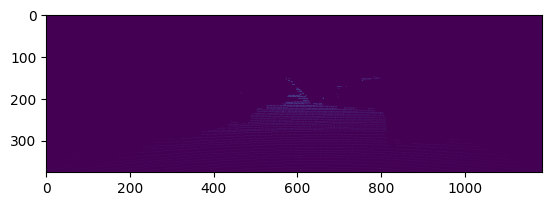

In [13]:
from tools.visualize_util import plt_show
plt_show(depth,rgb=False)